## FLAGS (IMPORTANT)

In [12]:
VALIDATE_NN = True
TRAIN = True
VALIDATE_SVM = True

## Constants

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [14]:
HIGH_COUNT = 100
LOW_FRAC = 1/64
ZERO_FRAC = 0.5
TEST_COUNT = 100

In [15]:
CENTRE = 4 * torch.ones(7)
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [16]:
LOW_RADIUS = 1.
HIGH_RADIUS = 2.

## Data

In [17]:
from scripts.data.orthants import generate_train_data

In [18]:
X_train, Y_train, orthant_counts = generate_train_data(
    low_count=HIGH_COUNT,
    high_count=HIGH_COUNT,
    low_spread=0,
    high_spread=0,
    low_frac=LOW_FRAC,
    zero_frac=ZERO_FRAC,
    random_state=7357
)
X_train.shape, Y_train.shape

(torch.Size([25400, 7]), torch.Size([25400, 1]))

In [19]:
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDEX = i
ZERO_ORTHANT_INDEX

80

In [20]:
from scripts.data.orthants import generate_test_data

X_test, Y_test = generate_test_data(TEST_COUNT, random_state=7753)
X_test.shape, Y_test.shape

(torch.Size([128, 200, 7]), torch.Size([128, 200, 1]))

In [21]:
X_val, Y_val = X_test[ZERO_ORTHANT_INDEX], Y_test[ZERO_ORTHANT_INDEX]

In [22]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

In [23]:
X_total_0 = X_train[Y_train.squeeze()==0]
X_total_1 = X_train[Y_train.squeeze()==1]

In [24]:
from scripts.data.orthants import find_orthant

def obtain_closest_point_orthant(
    test_point: torch.Tensor,
    pos_points: torch.Tensor,
    neg_points: torch.Tensor
) -> torch.Tensor:
    pos_distances, neg_distances = torch.sqrt(torch.sum((test_point - pos_points)**2, dim=1)), torch.sqrt(torch.sum((test_point - neg_points)**2, dim=1))
    return torch.tensor([find_orthant(pos_points[torch.argmin(pos_distances)]), find_orthant(neg_points[torch.argmin(neg_distances)])])

In [25]:
import pandas as pd

closest_orthants_0 = pd.DataFrame(torch.cat([
    obtain_closest_point_orthant(x, X_total_0, X_total_1).reshape(1, -1) for x in X_test[ZERO_ORTHANT_INDEX][Y_test[ZERO_ORTHANT_INDEX].squeeze() == 0]
]), columns=['closest_positive_orthant', 'closest_negative_orthant'])
closest_orthants_1 = pd.DataFrame(torch.cat([
    obtain_closest_point_orthant(x, X_total_0, X_total_1).reshape(1, -1) for x in X_test[ZERO_ORTHANT_INDEX][Y_test[ZERO_ORTHANT_INDEX].squeeze() == 1]
]), columns=['closest_positive_orthant', 'closest_negative_orthant'])

In [26]:
from scripts.data.orthants import ORTHANTS

neighboring_orthants = []
for i in range(128):
    if (ORTHANTS[i] * ORTHANTS[ZERO_ORTHANT_INDEX]).sum() == 5:
        neighboring_orthants.append(i)
neighboring_orthants

[16, 64, 81, 82, 84, 88, 112]

In [27]:
closest_orthants_0['closest_positive_orthant'].value_counts(), closest_orthants_0['closest_negative_orthant'].value_counts() 

(16     43
 112    27
 64     16
 88     11
 81      2
 84      1
 Name: closest_positive_orthant, dtype: int64,
 16     47
 112    28
 64     23
 88      2
 Name: closest_negative_orthant, dtype: int64)

In [28]:
closest_orthants_1['closest_positive_orthant'].value_counts(), closest_orthants_1['closest_negative_orthant'].value_counts() 

(112    31
 16     31
 64     21
 88     14
 84      3
 Name: closest_positive_orthant, dtype: int64,
 16     33
 112    32
 64     22
 88     12
 84      1
 Name: closest_negative_orthant, dtype: int64)

In [29]:
X_empty_0 = X_val[Y_val.squeeze() == 0]
X_empty_1 = X_val[Y_val.squeeze() == 1]
X_empty_0.shape, X_empty_1.shape

(torch.Size([100, 7]), torch.Size([100, 7]))

## Neural network

In [19]:
device = 'cpu'

In [20]:
from scripts.models import SimpleNN
from scripts.train import train_model
from scripts.metrics import BinaryAccuracy

In [21]:
depths = [1, 2, 3, 4, 5]
widths = [32, 64, 128]
etas = [1e-4, 1e-3, 1e-2]
weight_decays = np.logspace(-5, 5, 11).tolist() 
weight_decays.append(0.0)

In [22]:
import json

if VALIDATE_NN:
    best_depth = None
    best_width = None
    best_eta = None
    best_weight_decay = None
    best_score = -torch.inf
else:
    with open('configs/nn/orthants-single-empty.json', 'r') as f:
        best_config = json.load(f)
    best_depth = best_config['depth']
    best_width = best_config['width']
    best_eta = best_config['eta']
    best_weight_decay = best_config['weight_decay']
    best_score = best_config['score']

In [23]:
import json

total_count = len(depths) * len(widths) * len(etas) * len(weight_decays)
curr_count = 0
EPOCHS = 10

if VALIDATE_NN:
    print(f'Cross-validating across {total_count} models.\n')

    for depth in depths:
        for width in widths:
            for eta in etas:
                for weight_decay in weight_decays:
                    model = SimpleNN(7, hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=weight_decay)
                    metric = BinaryAccuracy()

                    history = train_model(
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    curr_count += 1
                    score = history['val_score'][-1]
                    print(f'[{curr_count}/{total_count}] Depth: {depth}, width: {width}, lr: {eta}, lambda: {weight_decay} ==> score: {score:.6f}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_eta = eta
                        best_weight_decay = weight_decay
    best_config = {
        'score': float(best_score),
        'depth': best_depth,
        'width': best_width,
        'eta': best_eta,
        'weight_decay': best_weight_decay
    }
    with open('configs/nn/orthants-single-empty.json', 'w') as f:
        json.dump(best_config, f)

print(f'\nBest validation score after {EPOCHS} epochs: {best_score:.6f}')
print(f'Best configuration: depth: {best_depth}, width: {best_width}, lr: {best_eta}, lambda: {best_weight_decay}')


Best validation score after 10 epochs: 0.913194
Best configuration: depth: 3, width: 32, lr: 0.001, lambda: 0.0


In [29]:
best_model_nn = SimpleNN(7, hidden_layers=best_depth, hidden_units=best_width).to(device)

In [30]:
from scripts.utils import EarlyStopping

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = BinaryAccuracy()
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [31]:
if TRAIN:
    history = train_model(
        model=best_model_nn,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric=metric,
        epochs=500,
        early_stopping=early_stop,
        device=device,
        return_models=True
    )
    torch.save(best_model_nn.state_dict(), 'models/orthants-single-empty.pth')
else:
    best_model_nn.load_state_dict(torch.load('models/orthants-single-empty.pth'))

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.693414, Train score: 0.498622, Val loss: 0.693068, Val score: 0.496724
Epoch: 2 => Train loss: 0.689498, Train score: 0.521358, Val loss: 0.673891, Val score: 0.545597
Epoch: 3 => Train loss: 0.601576, Train score: 0.660335, Val loss: 0.529451, Val score: 0.746986
Epoch: 4 => Train loss: 0.481400, Train score: 0.766978, Val loss: 0.435203, Val score: 0.803132
Epoch: 5 => Train loss: 0.397284, Train score: 0.824065, Val loss: 0.362583, Val score: 0.844274
Epoch: 6 => Train loss: 0.332673, Train score: 0.870571, Val loss: 0.294636, Val score: 0.892099
Epoch: 7 => Train loss: 0.290936, Train score: 0.893061, Val loss: 0.291060, Val score: 0.894720
Epoch: 8 => Train loss: 0.271803, Train score: 0.902756, Val loss: 0.261969, Val score: 0.904940
Epoch: 9 => Train loss: 0.263783, Train score: 0.904774, Val loss: 0.247512, Val score: 0.915225
Epoch: 10 => Train loss: 0.252566, Train score: 0.910089, Val loss: 0.27

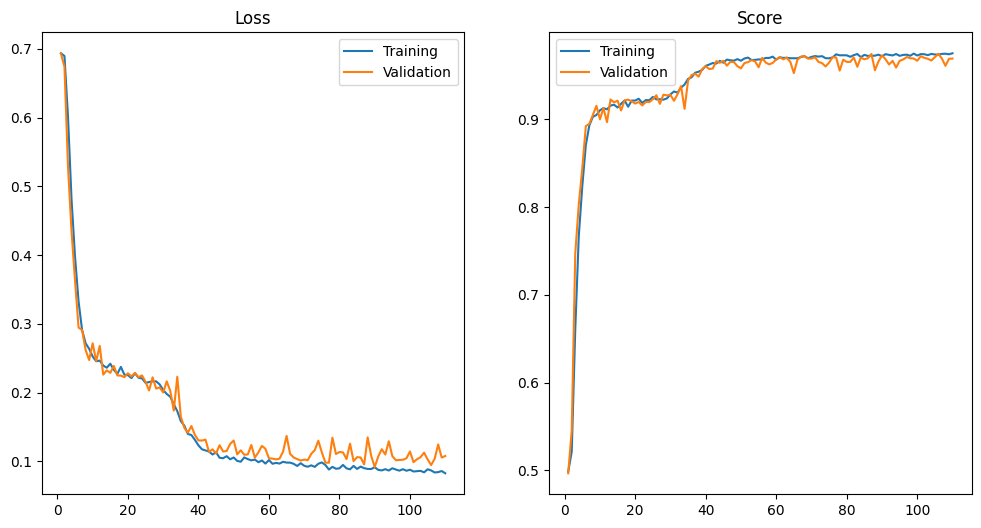

In [32]:
from scripts.utils import plot_train_history

if TRAIN:
    plot_train_history(history)

In [1]:
from scripts.ntk import get_ntk_feature_matrix
from matplotlib.animation import FuncAnimation, FFMpegWriter
import datetime as dt
import os

dist_00 = torch.tensor([find_orthant(X_total_0[torch.argmin(((x_test.reshape(1,-1)-X_total_0)**2).sum(dim=1))]) for x_test in X_empty_0])
dist_01 = torch.tensor([find_orthant(X_total_1[torch.argmin(((x_test.reshape(1,-1)-X_total_1)**2).sum(dim=1))]) for x_test in X_empty_0])
dist_10 = torch.tensor([find_orthant(X_total_0[torch.argmin(((x_test.reshape(1,-1)-X_total_0)**2).sum(dim=1))]) for x_test in X_empty_1])
dist_11 = torch.tensor([find_orthant(X_total_1[torch.argmin(((x_test.reshape(1,-1)-X_total_1)**2).sum(dim=1))]) for x_test in X_empty_1])

fig, ax = plt.subplots(2, 2, figsize=(15, 16))
FPS = 4

def plot_closest_points(i):
    model_i = history['models'][i]

    train_neg_grads = get_ntk_feature_matrix(X_total_0, model_i)
    train_pos_grads = get_ntk_feature_matrix(X_total_1, model_i)

    test_neg_grads = get_ntk_feature_matrix(X_empty_0, model_i)
    test_pos_grads = get_ntk_feature_matrix(X_empty_1, model_i)

    grad_dist_00 = torch.tensor([find_orthant(X_total_0[torch.argmin(((x_test.reshape(1,-1)-train_neg_grads)**2).sum(dim=1))]) for x_test in test_neg_grads])
    grad_dist_01 = torch.tensor([find_orthant(X_total_1[torch.argmin(((x_test.reshape(1,-1)-train_pos_grads)**2).sum(dim=1))]) for x_test in test_neg_grads])
    grad_dist_10 = torch.tensor([find_orthant(X_total_0[torch.argmin(((x_test.reshape(1,-1)-train_neg_grads)**2).sum(dim=1))]) for x_test in test_pos_grads])
    grad_dist_11 = torch.tensor([find_orthant(X_total_1[torch.argmin(((x_test.reshape(1,-1)-train_pos_grads)**2).sum(dim=1))]) for x_test in test_pos_grads])

    ax[0][0].scatter(range(TEST_COUNT), dist_00, c='r', label='Euclidean distance')
    ax[0][0].scatter(range(TEST_COUNT), grad_dist_00, c='g', label='Distance between grads')
    ax[0][0].legend()
    ax[0][0].set_title('Empty 0, others 0')
    ax[0][0].set_ylim(0, 128)

    ax[0][1].scatter(range(TEST_COUNT), dist_01, c='r', label='Euclidean distance')
    ax[0][1].scatter(range(TEST_COUNT), grad_dist_01, c='g', label='Distance between grads')
    ax[0][1].legend()
    ax[0][1].set_title('Empty 0, others 1')
    ax[0][1].set_ylim(0, 128)
    ax[0][1].set_yticks(range(128), range(128))

    ax[1][0].scatter(range(TEST_COUNT), dist_10, c='r', label='Euclidean distance')
    ax[1][0].scatter(range(TEST_COUNT), grad_dist_10, c='g', label='Distance between grads')
    ax[1][0].legend()
    ax[1][0].set_title('Empty 1, others 0')
    ax[1][0].set_ylim(0, 128)
    ax[1][0].set_yticks(range(128), range(128))

    ax[1][1].scatter(range(TEST_COUNT), dist_11, c='r', label='Euclidean distance')
    ax[1][1].scatter(range(TEST_COUNT), grad_dist_11, c='g', label='Distance between grads')
    ax[1][1].legend()
    ax[1][1].set_title('Empty 1, others 1')
    ax[1][1].set_ylim(0, 128)
    ax[1][1].set_yticks(range(128), range(128))

    plt.suptitle('Closest orthant vs point number, epoch '+str(i))

ani = FuncAnimation(fig, plot_closest_points, frames=len(history['models']), interval=1000/FPS, repeat=True)
writer = FFMpegWriter(fps=FPS, bitrate=1800, metadata=dict(artist='Me'))

now = dt.datetime.now().strftime("%d%m%Y_%H%M")
folder_name = 'animations/'+now
os.mkdir(folder_name)

ani.save(folder_name+'/closest_pts.mp4', writer=writer)

NameError: name 'torch' is not defined

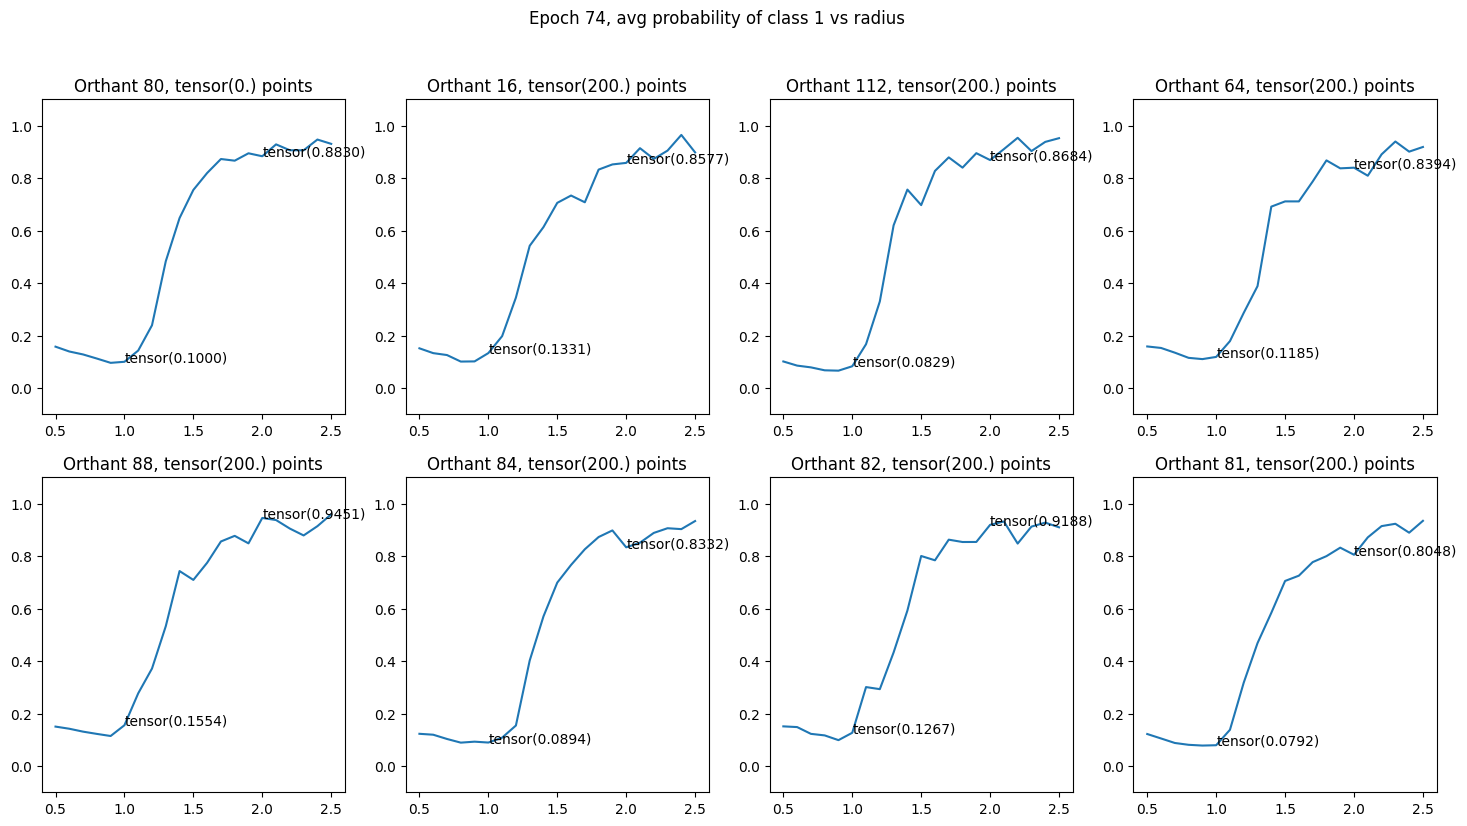

In [26]:
from scripts.utils import plot_radial_visualization

if TRAIN:
    plot_radial_visualization(
        models=history['models'],
        mp4_save_file_name='radial_1empty',
        orthant_counts=orthant_counts,
        main_orthant=ZERO_ORTHANT_INDEX,
        fps=4
    )

In [27]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

In [28]:
scores_nn.mean(), scores_nn[ZERO_ORTHANT_INDEX].mean()

(tensor(0.9256), tensor(0.9200))

## SVM

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [30]:
ntk = NTK(best_model_nn).get_ntk

In [31]:
model_base_ntk = SVC(kernel=ntk, max_iter=int(1e4))
params_ntk = {
    'C': np.logspace(-5, 5, 11)
}
best_params_ntk = {
    'C': None,
    'score': -np.inf
}

gammas = np.logspace(-5, 5, 11).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVC(kernel='rbf', max_iter=int(1e4))
params_rbf = {
    'C': np.logspace(-5, 5, 11),
    'gamma': gammas
}
best_params_rbf = {
    'C': None,
    'gamma': None,
    'score': -np.inf
}

scorer = make_scorer(accuracy_score)

In [ ]:
if VALIDATE_SVM:
    total_count = len(params_ntk['C'])
    curr_count = 0
    print(f'Cross-validating across {total_count} models.')
    for C in params_ntk['C']:
        curr_count += 1
        model_cv_ntk = SVC(kernel=ntk, C=C, max_iter=int(1e4))
        model_cv_ntk.fit(X_train, Y_train.squeeze())
        preds_train, preds_val = model_cv_ntk.predict(X_train), model_cv_ntk.predict(X_val)
        score_train, score_val = -accuracy_score(Y_train.squeeze(), preds_train), -accuracy_score(Y_val.squeeze(), preds_val)
        if score_val > best_params_ntk['score']:
            best_params_ntk['C'] = C
            best_params_ntk['score'] = score_val
        print(f'[{curr_count}/{total_count}]\tC:{C}, train score:{score_train}, val score:{score_val}')
    print(f"\nBest validation accuracy: {best_params_ntk['score']}, for C = {best_params_ntk['C']}")

In [ ]:
if VALIDATE_SVM:
    total_count = len(params_rbf['C']) * len(params_rbf['gamma'])
    curr_count = 0
    print(f'Cross-validating across {total_count} models.')
    for C in params_rbf['C']:
        for gamma in params_rbf['gamma']:
            curr_count += 1
            model_cv_rbf = SVC(kernel='rbf', C=C, gamma=gamma, max_iter=int(1e4))
            model_cv_rbf.fit(X_train, Y_train.squeeze())
            preds_train, preds_val = model_cv_rbf.predict(X_train), model_cv_rbf.predict(X_val)
            score_train, score_val = -accuracy_score(Y_train.squeeze(), preds_train), -accuracy_score(Y_val.squeeze(), preds_val)
            if score_val > best_params_rbf['score']:
                best_params_rbf['C'] = C
                best_params_rbf['gamma'] = gamma
                best_params_rbf['score'] = score_val
            print(f'[{curr_count}/{total_count}]\tC:{C}, gamma:{gamma}, train score:{score_train}, val score:{score_val}')
    print(f"\nBest validation accuracy: {best_params_rbf['score']}, for C = {best_params_rbf['C']}, gamma = {best_params_rbf['gamma']}")

In [34]:
import json

if VALIDATE_SVM:
    if best_params_rbf['score'] >= best_params_ntk['score']:
        best_model_km = SVC(C=best_params_rbf['C'], kernel='rbf', gamma=best_params_rbf['gamma'])
        best_config = {
            'kernel': 'rbf',
            'C': best_params_rbf['C'],
            'gamma': best_params_rbf['gamma']
        }
        with open('configs/svm/orthants-single-empty.json', 'w') as f:
            json.dump(best_config, f)
    else:
        best_model_km = SVC(C=best_params_ntk['C'], kernel=ntk)
        best_config = {
            'kernel': 'ntk',
            'C': best_params_ntk['C']
        }
        with open('configs/svm/orthants-single-empty.json', 'w') as f:
            json.dump(best_config, f)
else:
    with open('configs/svm/orthants-single-empty.json', 'r') as f:
        best_config = json.load(f)
    if best_config['kernel'] == 'rbf':
        best_model_km = SVC(C=best_config['C'], gamma=best_config['gamma'])
    else:
        best_model_km = SVC(kernel=ntk, C=best_config['C'])

In [35]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(gamma=0.1)

In [36]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(1.0, 1.0)

In [37]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

In [38]:
scores_km.mean(), scores_km[ZERO_ORTHANT_INDEX].mean()

(0.99609375, 0.5)

## NN vs SVM

Text(0.5, 0.98, 'Accuracy per orthant')

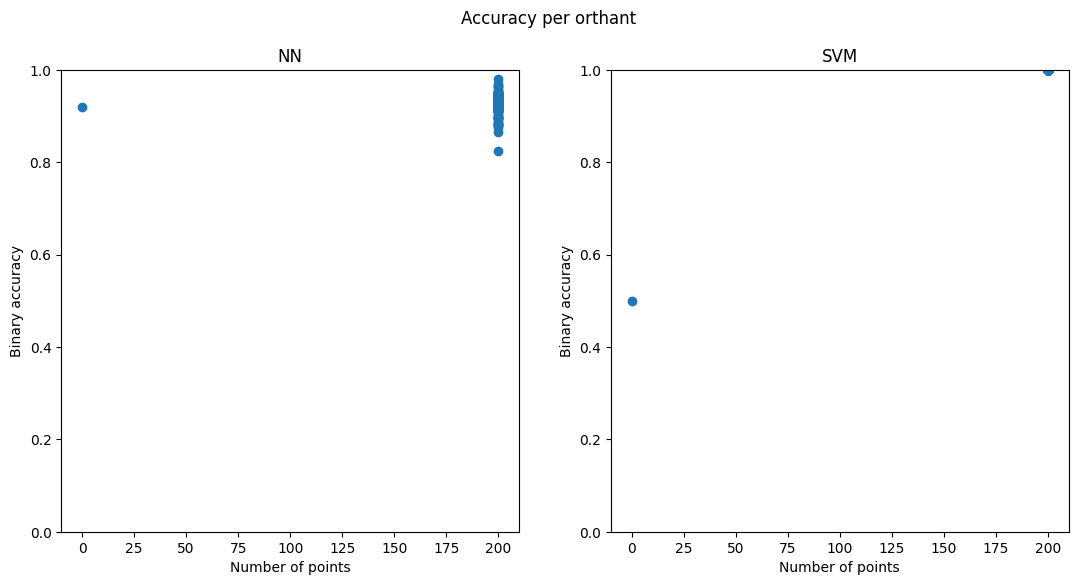

In [39]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('NN')

plt.subplot(122)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('SVM')

plt.suptitle('Accuracy per orthant')